FileName: 1.0-initial_model_development.ipynb

Developer: Tanmoy Das
Date: June 11, 2023

Outline of this script:
1. model1
2. model2

Both models are implemented in following steps:
1. Input data
2. Optimization Model
3. Output in a form of Network Diagram

# Data

In [1]:
# import custom functions
import data_preparation
import custom_func
from model import Model
from draw_network import DrawNetworkDiagram

import pandas as pd
import geopandas as gpd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import data
spill_data = pd.read_excel('../data/processed/data_100_oil_spills.xlsx', sheet_name='spills', header=0).copy()
station_data = pd.read_excel('../data/raw/data_oil_spill_resource_allocation_Arctic_2023.xlsx', sheet_name='stations', header=0).copy()
input_parameters = pd.read_excel('../data/raw/data_oil_spill_resource_allocation_Arctic_2023.xlsx', sheet_name='Estimated parameters', header=0).copy()
sensitivity_dataR = gpd.read_file('../data/gis map/ArcGIS_data/Sensitivity_data/Sensitivity_data5.shp').copy()

## Data Preprocessing

In [3]:
Stations, OilSpills, ResourcesD, Demand, Availability, Eff, Distance, TimeR, Cf_s, CostU \
= data_preparation.generate_input_data(station_data, spill_data, input_parameters)
coordinates_spill = custom_func.extract_spill_coordinate(spill_data)
coordinates_st = custom_func.extract_station_coordinate(station_data)

SizeSpill = SizeSpill_R = list(spill_data['Spill size']).copy()
Sensitivity_R = custom_func.calculate_sensitivity(coordinates_spill[0], sensitivity_dataR)

['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20']


In [4]:
# normalize  # (x_0-x_min)/(x_max-x_min)
SizeSpill_n = dict(zip(OilSpills, custom_func.normalize(SizeSpill_R, min(SizeSpill_R), max(SizeSpill_R))))
Sensitivity_n = dict(zip(OilSpills, custom_func.normalize(Sensitivity_R, min(Sensitivity_R), max(Sensitivity_R))))
Distance_n = dict(zip(Distance.keys(), custom_func.normalize(Distance.values(), min(Distance.values()), max(Distance.values()))))
Effectiveness_n = dict(zip(Eff.keys(), custom_func.normalize(Eff.values(), min(Eff.values()), max(Eff.values()))))

## Scalar inputs of the models

In [5]:
DistanceMax = 10
BigM = 10**20
current_vs_proposed = 'proposed' # current
MaxFO = 1
Budget = 10**12
W = [0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
QuantityMin = 2

# Model Configuration 1

In [6]:
NumberStMax_m1 = 4

## Run the optimization model

In [7]:
model01, select, deploy, mvars, names, values, objValues, \
        spill_df, station_df, cover_1s, select_1s, deploy_1s, MeanResponseTime, coverage_percentage, assignment  \
    = Model.solve(Stations, OilSpills, ResourcesD, coordinates_st, coordinates_spill, SizeSpill, SizeSpill_n,
          Demand, Sensitivity_R, Sensitivity_n, Eff, Effectiveness_n, Availability, NumberStMax_m1, Distance, Distance_n,
          W, QuantityMin, DistanceMax, Cf_s, CostU, Budget,
          BigM, MaxFO)

--------------MIP-moo--------
Set parameter Username
Academic license - for non-commercial use only - expires 2025-05-03
Set parameter PoolSolutions to value 1024
Set parameter PoolGap to value 0.8
Set parameter LogFile to value "../models/model_moo(May 03,0141).log"
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (mac64[arm] - Darwin 23.2.0 23C71)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1832 rows, 1436 columns and 4534 nonzeros
Model fingerprint: 0x019b5a04
Variable types: 1062 continuous, 374 integer (374 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+25]
  Objective range  [1e-02, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+12]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.

---------------------------------------------------------------------------
Multi-objectives: starting optimization with 2 object

## Network Diagram

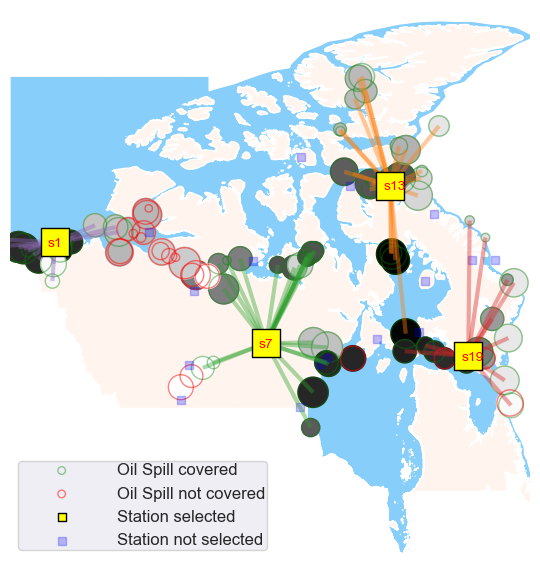

In [8]:
# Draw Network Diagram
assignment_line_m1 = DrawNetworkDiagram.draw_network_diagram(DistanceMax, NumberStMax_m1, Sensitivity_R, spill_df, station_df, MeanResponseTime, coverage_percentage, assignment, deploy_1s, select_1s, current_vs_proposed)
# Fig5b

## Table 3 (model 2)

In [9]:
input_output_df = pd.DataFrame(index=range(1), columns=['Max no of stations', 'Max distance','Coverage Percentage', 'Mean Response Time', 'Objective 1', 'Objective 2'])
input_output_df.iloc[0,0] = NumberStMax_m1
input_output_df.iloc[0,1] = DistanceMax
input_output_df.iloc[0,2] = coverage_percentage
input_output_df.iloc[0,3] = MeanResponseTime
input_output_df.iloc[0,4] = objValues[0::2][1]
input_output_df.iloc[0,5] = objValues[1::2][1]
input_output_df

,Max no of stations,Max distance,Coverage Percentage,Mean Response Time,Objective 1,Objective 2
0,4,10,78,7.94,1006.00302,525.0


## Resource allocation from facilities (Table 5)

In [10]:
assignment_line_m1 = pd.DataFrame(columns=list(assignment.columns.values))
for i, o in enumerate(assignment['Spill #'].unique()):
    minD = min(assignment.loc[assignment['Spill #'] == o]['Distance'])
    df = assignment.iloc[np.where(assignment['Distance'] == minD)[0]]
    assignment_line_m1 = pd.concat([assignment_line_m1, df])

resource_allocation_m1 = assignment_line_m1[['Station no.', 'Resource Type', 'Quantity deployed']]
resource_allocation_m1 = resource_allocation_m1.sort_values(by=['Station no.'])
resource_allocation_m1 = resource_allocation_m1.groupby(['Station no.', 'Resource Type'])['Quantity deployed'].mean().reset_index()
resource_allocation_m1['Facility'] = 'Proposed'
resource_allocation_m1

,Station no.,Resource Type,Quantity deployed,Facility
0,s1,c,26.833333,Proposed
1,s1,i,55.750000,Proposed
2,s1,m,60.000000,Proposed
3,s13,c,27.875000,Proposed
4,s13,i,67.000000,Proposed
5,s13,m,48.400000,Proposed
6,s19,c,34.857143,Proposed
7,s19,m,40.666667,Proposed
8,s7,c,61.833333,Proposed
9,s7,i,49.000000,Proposed


# Model Configuration 2

In [11]:
NumberStMax_m2 = 8

In [12]:
model02, select_m2, deploy_m2, mvars_m2, names_m2, values_m2, objValues_m2, \
        spill_df_m2, station_df_m2, cover_1s_m2, select_1s_m2, deploy_1s_m2, MeanResponseTime_m2, coverage_percentage_m2, assignment_m2  \
    = Model.solve(Stations, OilSpills, ResourcesD, coordinates_st, coordinates_spill, SizeSpill, SizeSpill_n,
          Demand, Sensitivity_R, Sensitivity_n, Eff, Effectiveness_n, Availability, NumberStMax_m2, Distance, Distance_n,
          W, QuantityMin, DistanceMax, Cf_s, CostU, Budget,
          BigM, MaxFO)

--------------MIP-moo--------
Set parameter PoolSolutions to value 1024
Set parameter PoolGap to value 0.8
Set parameter LogFile to value "../models/model_moo(May 03,0141).log"
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (mac64[arm] - Darwin 23.2.0 23C71)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1832 rows, 1436 columns and 4534 nonzeros
Model fingerprint: 0xf239901e
Variable types: 1062 continuous, 374 integer (374 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+25]
  Objective range  [1e-02, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+12]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.

---------------------------------------------------------------------------
Multi-objectives: starting optimization with 2 objectives ... 
---------------------------------------------------------------------------

Mult

## Table 3 (model 6)

In [13]:
input_output_df_m2 = pd.DataFrame(index=range(1), columns=['Max no of stations', 'Max distance (kms)', 'Coverage Percentage', 'Mean Response Time','Objective 1', 'Objective 2'])
input_output_df_m2.iloc[0,0] = NumberStMax_m2
input_output_df_m2.iloc[0,1] = DistanceMax
input_output_df_m2.iloc[0,4] = coverage_percentage_m2
input_output_df_m2.iloc[0,5] = MeanResponseTime_m2
input_output_df_m2.iloc[0,2] = objValues_m2[0::2][1]
input_output_df_m2.iloc[0,3] = objValues_m2[1::2][1]
input_output_df_m2

,Max no of stations,Max distance (kms),Coverage Percentage,Mean Response Time,Objective 1,Objective 2
0,8,10,1149.278387,-5592.989139,99,7.39
